In [1]:
import numpy as np , pandas as pd
import torch
import torch.nn as nn
import einops
import pickle

import configparser


In [6]:
config = configparser.ConfigParser()
config.read('settings.ini')

config= {key: int(value) for key, value in config['INCOME_DATASET'].items()}
config

{'vocab_length': 21979,
 'val_split': 20,
 'test_split': 10,
 'epochs': 2,
 'n_embed': 992,
 'n_heads': 31,
 'context_window': 38,
 'transformer_blocks': 2,
 'batch_size': 32,
 'random_seed': 123}

In [7]:
# load the encoded variables
file_path = 'encoded_vars/token_vars_income.pkl'

with open(file_path, 'rb') as file:
    loaded_variable = pickle.load(file)

print("Loaded variable :",loaded_variable.keys())
df = loaded_variable["df"]
col_code = loaded_variable["col_code"]
tokenizer = loaded_variable["tokenizer"]

Loaded variable : dict_keys(['col_code', 'df', 'tokenizer'])


In [11]:
test_set = torch.load("encoded_vars/test_split.pt")

In [12]:
class SingleHead(nn.Module):
    """
    Implements a single head of attention (unmasked)
    """

    def __init__(self,R,head_size,manual_seed=123):
        super().__init__()
        # single head
        self.head_size = head_size
        self.scale = 1/ torch.sqrt(torch.tensor(self.head_size))
        self.R = torch.tensor(R)
        self.Q = nn.Parameter( torch.randn(self.R,head_size))
        self.K = nn.Parameter( torch.randn(self.R,head_size))
        self.V = nn.Parameter( torch.randn(self.R,head_size))

    def forward(self,x):
        q = x @ self.Q # (B,T,R) * (R,h) => (B,T,R) x (B,R,h) => (B,T,h) 
        k = x @ self.K
        v = x @ self.V

        comm = q @ einops.rearrange(k,"B T h -> B h T") # (B,T,h) @ (B,h,T) => B,T,T @ each tokens interaction with each token would be T,T
        att1 = nn.functional.softmax(comm * self.scale,dim=2) # along tokens head
        attention = att1 @ v # B,T,T @ B,T,h => B,T,h
        return attention

In [13]:
class Multihead(nn.Module):
    def __init__(self,R,n_heads,seed=123):
        self.R = R
        assert R % n_heads == 0 , "n_heads is not divisible by R"
        self.head_size = self.R // n_heads
        self.n_heads = n_heads

        super().__init__()
        self.multiheads = nn.ModuleList(
            [SingleHead(self.R,self.head_size)  for _ in range(self.n_heads)]
        )

    def forward(self,x):
        return torch.cat([head(x) for head in self.multiheads],dim=2)

In [14]:
class IncomeTransformer(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.context_window = config["context_window"]
        self.n_embed = config["n_embed"]
        self.n_heads = config["n_heads"]
        self.n_vocab = config["vocab_length"]
        self.transformer_blocks = config["transformer_blocks"]

        #==== Token (C) and positional Embedding (pe)
        self.C = nn.Embedding(self.n_vocab,self.n_embed) # token embedding
        self.pe = nn.Parameter(torch.randn(1,self.n_embed)) # position embedding

        #===== Transformer Blocks
        self.multi_heads = Multihead(R=self.n_embed, n_heads=self.n_heads)
        self.layer_norm = nn.LayerNorm(self.n_embed) #at the end of the transformer block

        #==== MLP Head
        self.mlp_head0 = nn.Linear(self.context_window * self.n_embed , self.n_embed)
        self.mlp_head1 = nn.Linear(self.n_embed,self.n_vocab) # logits



    def forward(self,x):
        emb = self.C(x) # token emb
        emb += self.pe # add pos emb

        # write a loop later : 2 blocks
        attn = self.multi_heads(emb)
        # skip connection
        skip = torch.nn.functional.leaky_relu(attn) + emb
        normed = self.layer_norm(skip)# layer norm and skip connection

        # flatten
        normed = einops.rearrange(normed,"b t e -> b (t e)")
        x = self.mlp_head0(normed)
        logits = self.mlp_head1(x) # logits

        return logits

    def calculate_loss(self,x,y):
        logits = self(x)
        return logits , nn.functional.cross_entropy(logits,y)

    def generate(self,seed = [0] * 38,verbose=False):
        generation = list()
        i = 0
        while True:
            if i > 50:
                # clearly untrained
                break
            if verbose:
                print(seed)
            logits = self(torch.tensor(seed).view(1,-1))
            probs = nn.functional.softmax(logits,dim=1)
            prediction = torch.multinomial(probs,num_samples=1)
            generation.append(prediction.item())
            if prediction.item() == 21976:
                break
            seed = seed[1:] + [prediction.item()]
            if verbose:
                print(prediction.item())
            i = i+1
        return generation



model = IncomeTransformer(config)

In [16]:
# our trained model
model = torch.load('model_complete.pth')
model.eval()

IncomeTransformer(
  (C): Embedding(21979, 992)
  (multi_heads): Multihead(
    (multiheads): ModuleList(
      (0-30): 31 x SingleHead()
    )
  )
  (layer_norm): LayerNorm((992,), eps=1e-05, elementwise_affine=True)
  (mlp_head0): Linear(in_features=37696, out_features=992, bias=True)
  (mlp_head1): Linear(in_features=992, out_features=21979, bias=True)
)

In [17]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
class TokenDataset(Dataset):
    def __init__(self, encoded_docs):
        self.encoded_docs = encoded_docs
        self.context_window = len(self.encoded_docs[0])
        self.start_seed = [0] * (self.context_window)

        # this is very expensive aviod reinit
        def compile_dataset():
            X,y  = [],[]
            for row in tqdm(self.encoded_docs):
                context = self.start_seed # take account of start token
                for token in row:
                    X.append(context)
                    y.append(token)
                    context = context[1:] + [token]

            X = torch.tensor(X)
            y = torch.tensor(y)
            return X,y

        self.X , self.y = compile_dataset()


    def __len__(self):
        return len(self.encoded_docs)


    def __getitem__(self, idx):
        inputs = self.X[idx]
        targets = self.y[idx]
        return torch.tensor(inputs), torch.tensor(targets)

In [18]:
testDataset = TokenDataset(test_set)
test_loader = DataLoader(testDataset, batch_size=32, shuffle=True)

100%|██████████| 977/977 [00:00<00:00, 6134.93it/s]


In [20]:
loss =[]
with torch.no_grad(): # this is more explicit though:
    for X , y in test_loader:
        # forward pass
        _,test_loss = model.calculate_loss(X,y)
        loss.append(test_loss)
        

/var/folders/f0/_f_gy0t91jqchv14f0hcl_gh0000gn/T/ipykernel_92029/468654311.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(inputs), torch.tensor(targets)
/var/folders/f0/_f_gy0t91jqchv14f0hcl_gh0000gn/T/ipykernel_92029/468654311.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(inputs), torch.tensor(targets)


In [23]:
test_loss = np.array(test_loss)
test_loss.mean()

1.430558

In [26]:
# make more generations 
n_generations = 1_000
gens = []
for i in tqdm(range(n_generations)):
    while True:
        sample = model.generate()
        if len(sample) == config["context_window"]:
            break
    gens.append(sample)

100%|██████████| 1000/1000 [30:41<00:00,  1.84s/it]  


In [28]:
from local_utils import tokenize_dataset , read_dataset , decoder

In [35]:
synthetic = list()
for eg in gens:
    try:
        decoded_eg = decoder(eg,df,col_code)
        synthetic.append(decoded_eg)
    except KeyError:
        pass
        

In [37]:
synthetic_df = pd.DataFrame(synthetic,columns=df.columns)
synthetic_df

,start,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,end
0,<start>,26.91349,State-gov,23740,Bachelors,12.93582,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.00000,0.00000,34.12397,United-States,>50K,<end>
1,<start>,27.94126,Private,176137,HS-grad,8.93521,Never-married,Craft-repair,Not-in-family,White,Male,0.00000,0.00000,39.64639,United-States,<=50K,<end>
2,<start>,41.79034,Local-gov,321851,Doctorate,15.95863,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.00000,54.59815,United-States,>50K,<end>
3,<start>,47.18696,Private,249072,Assoc-voc,10.91349,Married-civ-spouse,Tech-support,Husband,White,Male,0.00000,0.00000,39.64639,United-States,<=50K,<end>
4,<start>,27.94126,Private,176137,HS-grad,8.93521,Never-married,Adm-clerical,Not-in-family,White,Female,0.00000,0.00000,39.64639,United-States,<=50K,<end>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,<start>,48.45972,Private,221936,Bachelors,12.93582,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.00000,47.94239,United-States,>50K,<end>
621,<start>,40.77909,?,277783,Masters,13.87377,Divorced,Exec-managerial,Own-child,White,Male,0.00000,0.00000,35.87354,United-States,<=50K,<end>
622,<start>,22.95875,Private,31606,Bachelors,12.93582,Never-married,Prof-specialty,Not-in-family,White,Male,0.00000,0.00000,39.64639,United-States,<=50K,<end>
623,<start>,34.91585,Private,195516,7th-8th,3.97490,Divorced,Transport-moving,Unmarried,White,Male,0.00000,0.00000,29.96410,United-States,<=50K,<end>


In [38]:
synthetic_df.to_csv("synthetic_income.csv")

In [42]:

FLOAT_COLS = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
for col in FLOAT_COLS:
    synthetic_df[col] = synthetic_df[col].astype(float)


In [43]:
synthetic_df.dtypes

start              object
age               float64
workclass          object
fnlwgt             object
education          object
education_num     float64
marital_status     object
occupation         object
relationship       object
race               object
sex                object
capital_gain      float64
capital_loss      float64
hours_per_week    float64
native_country     object
income             object
end                object
dtype: object

<Axes: ylabel='Frequency'>

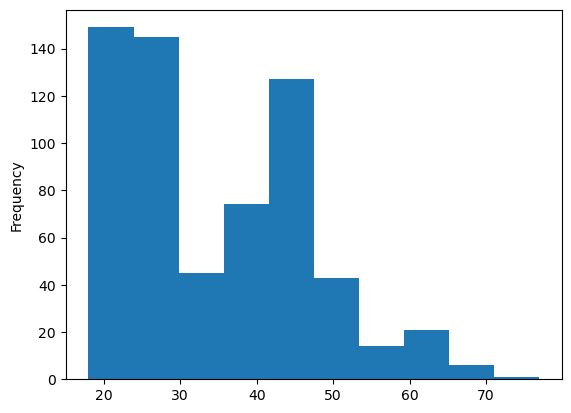

In [45]:
synthetic_df["age"].plot(kind="hist")

<Axes: ylabel='Frequency'>

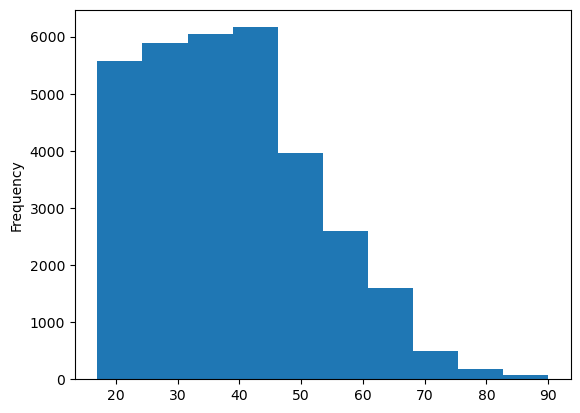

In [46]:
df["age"].plot(kind="hist")

In [48]:
df_sample = df.sample(synthetic_df.shape[0])
df_sample.shape

(625, 17)

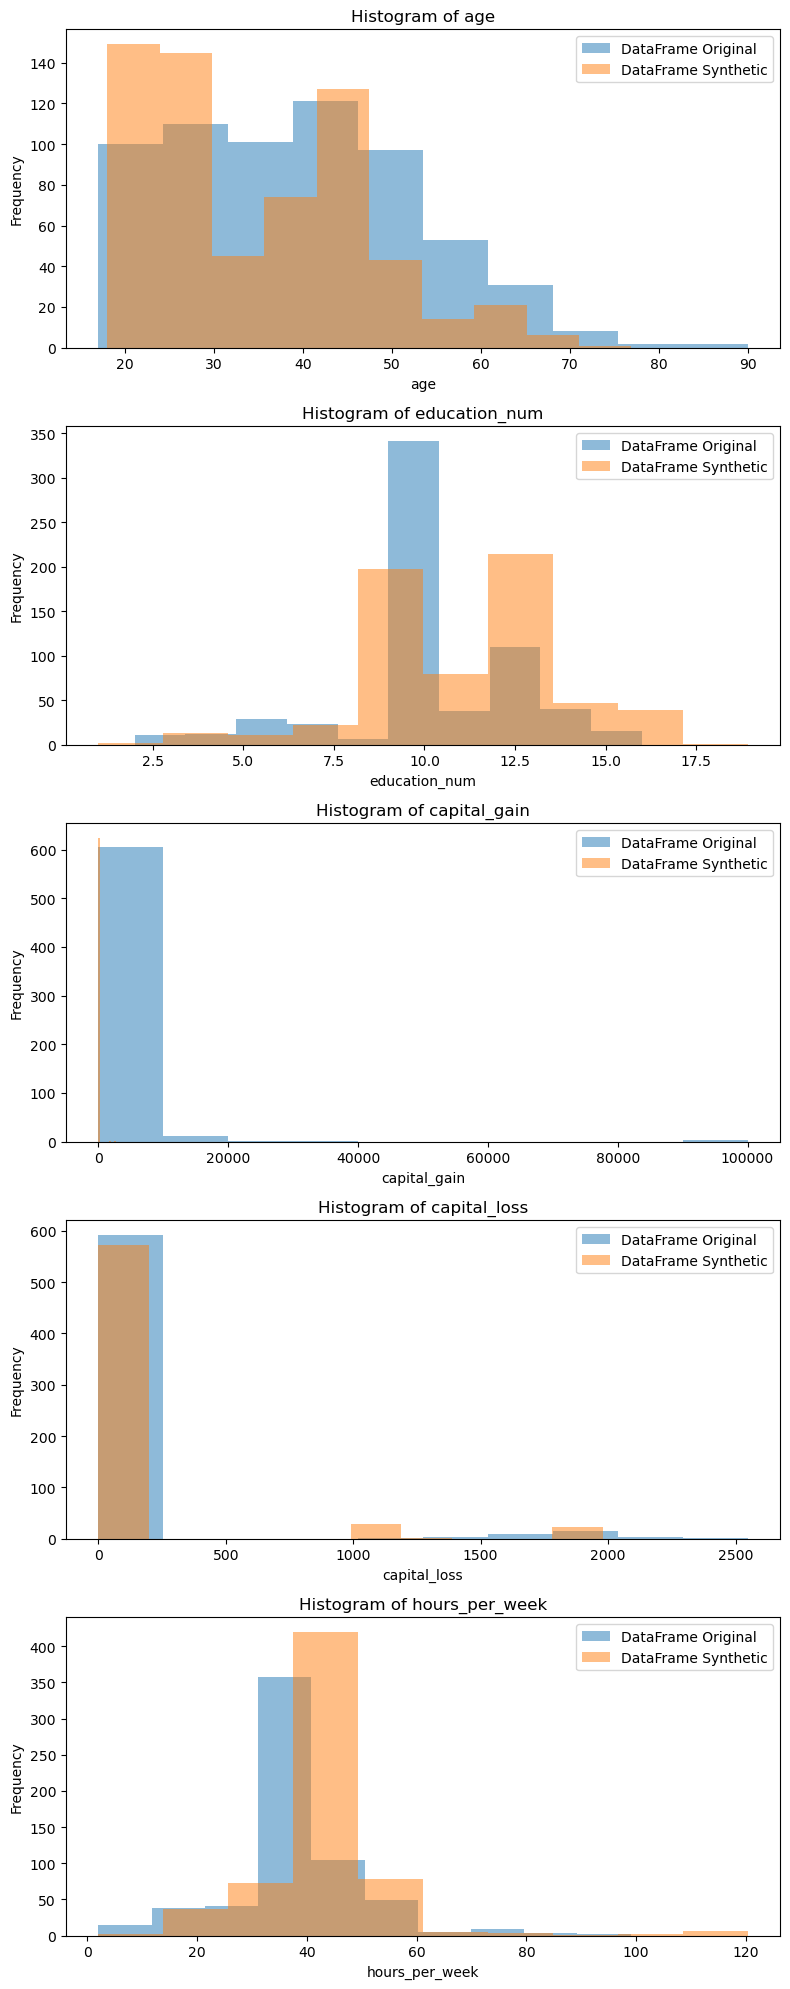

In [49]:
# List of columns
import matplotlib.pyplot as plt
columns = FLOAT_COLS

# Number of columns
num_columns = len(columns)

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(8, num_columns * 4))

# Plot histograms for each column
for i, column in enumerate(columns):
    ax = axes[i] if num_columns > 1 else axes
    df_sample[column].plot.hist(ax=ax, alpha=0.5, label='DataFrame Original', bins=10)
    synthetic_df[column].plot.hist(ax=ax, alpha=0.5, label='DataFrame Synthetic', bins=10)
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()